0.0


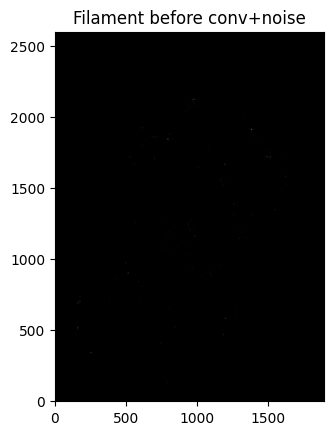

In [ ]:
import photutils 

# set the FWHM of the filament
fwhmval=3 #16pc scale at 5.24 parcecs per pixel --> 3 pixels 

import numpy as np
import matplotlib.pyplot as plt
from photutils.datasets import make_noise_image
from photutils.psf import CircularGaussianPRF, make_psf_model_image
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.io import fits
from skimage.morphology import skeletonize
import cv2

#make a test filament
original_image_path = "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W/Composites/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc_Composites.fits"
with fits.open(original_image_path) as hdul:
    coords_data = hdul[0].data
    header_1 = hdul[0].header

#make a test filament
original_image_path =  "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W/CDD/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc.fits"
with fits.open(original_image_path) as hdul:
    data = hdul[0].data
    header = hdul[0].header


kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)
dilated_image = cv2.morphologyEx(coords_data, cv2.MORPH_CLOSE, kernel)
dilated_image = skeletonize(dilated_image)
coords_data= dilated_image.astype(np.uint8)
    
odata=data #original no noise

plt.imshow(data, origin='lower', cmap='gray')
plt.title('Filament before conv+noise')
plt.show()


In [24]:
#must define uncertainty in data and subtract background
import copy
from photutils.background import Background2D, MedianBackground
Scalepix = 5.24
noise_min = 10**-2

threshold = 10**-20 #pixels below this value will be seeds for mask

data_to_mask = data

mask_copy = copy.deepcopy(data_to_mask)

#Dilate White Pixels
mask_copy[mask_copy > threshold] = 255
mask_copy = mask_copy.astype(np.uint8)
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)
dilated_image = cv2.dilate(mask_copy, kernel, iterations= 5) 

#threshold other way
copy_image = copy.deepcopy(data_to_mask).astype(np.float32)
copy_image[dilated_image < threshold] = np.nan
mask = np.isnan(copy_image)

#set up binary mask
binary_mask = np.zeros_like(copy_image, dtype=np.uint8)
binary_mask[mask] = 255
binary_mask[~mask] = 0

#dilate the mask
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)
dilated_mask = cv2.dilate(binary_mask, kernel, iterations=1)

dilated_image = copy.deepcopy(data_to_mask).astype(np.float32)
dilated_image[dilated_mask==255] = np.nan

#make a mask based on dilated image, true value indicates pixel should be masked
mask = np.isnan(dilated_image)
assert(not np.isnan(mask).any())

                
#subtract bkg
bkg_estimator = MedianBackground()

#set box size
box_size = round(10.*Scalepix/2)*2+1

# if(box_size < .02* np.min((np.shape(data)[0], np.shape(data)[1]))):
#     print("Correcting box size")
#     box_size = int(.02*np.min((np.shape(data)[0], np.shape(data)[1]))) * 2 + 1 #Make box 2% of smaller image dimension...appears to work well

bkg = Background2D(data, box_size=box_size, coverage_mask = mask, exclude_percentile = 10, filter_size=(3,3), bkg_estimator=bkg_estimator) #Very different RMS with mask. Minimum noise is MUCH larger. 

data -= bkg.background #subtract bkg

data[data < 0] = 0 #Elimate neg values sinc this is over estimating the background. 

noise = bkg.background_rms #bkg sub/RMS map

noise[noise < noise_min] = noise_min #replace unphysical and absent noise with 10^-3 just to avoid division by zero


#data is background subtracted and noise array generated

In [25]:
#set up for forced photometry, NOT allowing positions along filament to vary (only flux, which I also bound in the nearly-positive range)
#note I originally boosted the model FWHM to account for pixelization in pre-convolved filament, but this made fit scaled high w.r.t. image (leaving strong negative scar)
psf_model = CircularGaussianPRF(flux=1, fwhm=(fwhmval)/2.35)
psf_model.x_0.fixed = True
psf_model.y_0.fixed = True
psf_model.flux.min = -1. * np.std(noise)
psf_model.fixed
psf_model.bounds

{'flux': (-0.05544706124041625, None), 'x_0': (None, None), 'y_0': (None, None), 'fwhm': (1.1754943508222875e-38, None)}

In [34]:
import numpy as np
from astropy.table import QTable
from photutils.psf import PSFPhotometry

# Find nonzero pixel coordinates
y_coords, x_coords = np.where(coords_data > 0)

# Create a new QTable with these coordinates
init_params = QTable()
init_params['x'] = x_coords
init_params['y'] = y_coords

# Define PSF fitting region
psf_shape = (int(4. * np.ceil(fwhmval) + 1), int(4. * np.ceil(fwhmval) + 1))
fit_shape = psf_shape
print(f"PSF Shape: {psf_shape}")

psfphot = PSFPhotometry(psf_model, fit_shape, aperture_radius=5)

# Perform PSF fitting
phot = psfphot(data, error=noise, init_params=init_params)

print(phot['flux_fit'])


PSF Shape: (13, 13)
      flux_fit     
-------------------
 0.8718304704283064
 1.1933496100911958
 1.1838888929496485
  1.056310818374177
 0.8693446929213425
 0.9435546544475318
 0.9554109775075899
 0.8646276838999317
0.36341952345655726
 0.6212895157758167
                ...
  0.322762369046117
 0.6273043894312814
 0.7581150756491124
 0.6959849041736201
0.41601160166922374
0.47775021285730795
  0.600327504191224
 0.7338955203643311
 0.7136032906433099
  0.449170327430722
Length = 96629 rows


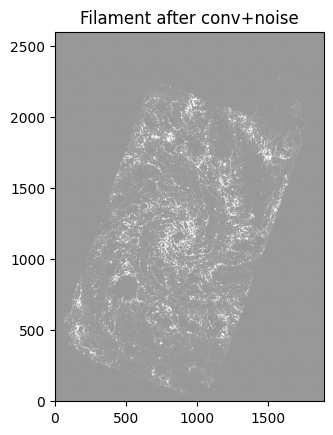

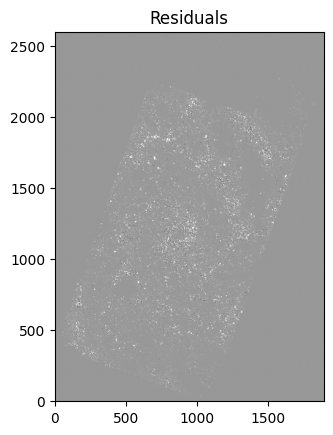

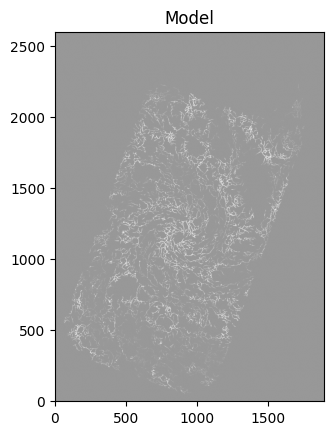

In [ ]:
# Compute residuals and model
resid = psfphot.make_residual_image(data)
model = data - resid  # Model is data minus residuals
save_path =  "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W_CDDss0016pc_ModelMap.fits"

# Save the model as a FITS file
hdu = fits.PrimaryHDU(model, header =header)
hdu.writeto(save_path, overwrite=True)


# Display images
plt.imshow(data, origin='lower', cmap='gray', vmin=-3.*np.std(data), vmax=np.percentile(data, 99))
plt.title('Filament after conv+noise')
plt.show()

plt.imshow(resid, origin='lower', cmap='gray', vmin=-3.*np.std(data), vmax=np.percentile(data, 99))
plt.title('Residuals')
plt.show()

plt.imshow(model, origin='lower', cmap='gray', vmin=-3.*np.std(data), vmax=np.percentile(data, 99))
plt.title('Model')
plt.show()

print(np.sum(model))
#still getting oversubtraction of filament fit until we figure out why fit intensity is too high